In [78]:
!pip install -Uqq fastai duckduckgo_search
!pip install timm

In [98]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(term, max_images=200):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')   #  burada neden itemgot mage") bır işleve ıhtıyac duyduk.

In [80]:
from fastdownload import download_url

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *


In [81]:
searches = 'Simmental','Holstein','Hereford','Angus','Charolais','Limousin','Jersey','Brown Swiss'
path = Path('content/what_kind_of_cow')
from time import sleep  #    sleep her bır ıcın 10 sanıye bekletır.

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} cow photo'))
    sleep(10)  # Pause between searches to avoid over-loading server

Searching for 'Simmental cow photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Searching for 'Holstein cow photo'
Searching for 'Hereford cow photo'
Searching for 'Angus cow photo'
Searching for 'Charolais cow photo'
Searching for 'Limousin cow photo'
Searching for 'Jersey cow photo'
Searching for 'Brown Swiss cow photo'


In [82]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

In [83]:
cows = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

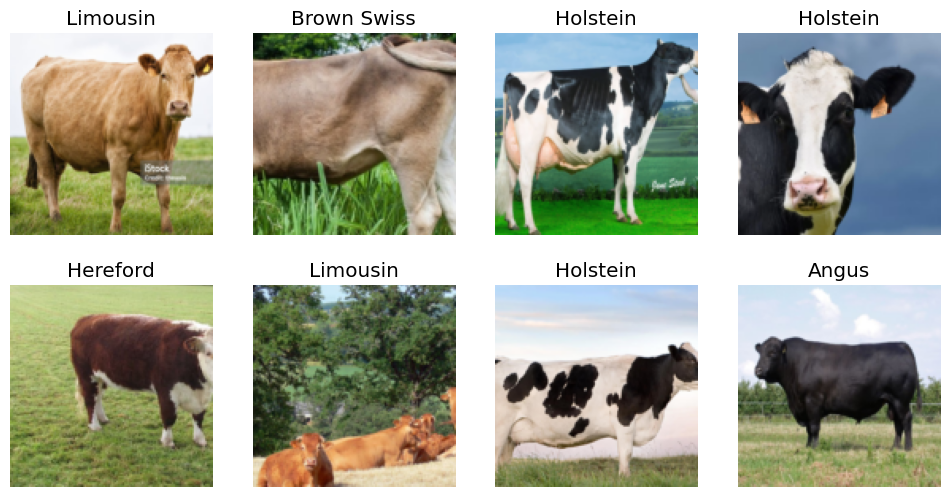

In [84]:
cows = cows.new(item_tfms=RandomResizedCrop(128, min_scale=0.3)) # randomresizedcrop showed me different parts of photograph

dls = cows.dataloaders(path)
dls.show_batch(max_n=8)


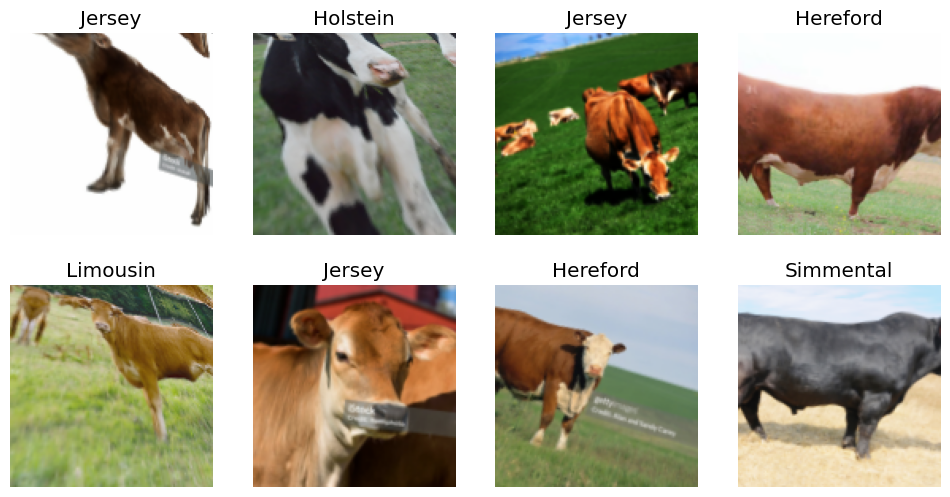

In [85]:
cows = cows.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cows.dataloaders(path)
dls.show_batch(max_n=8)

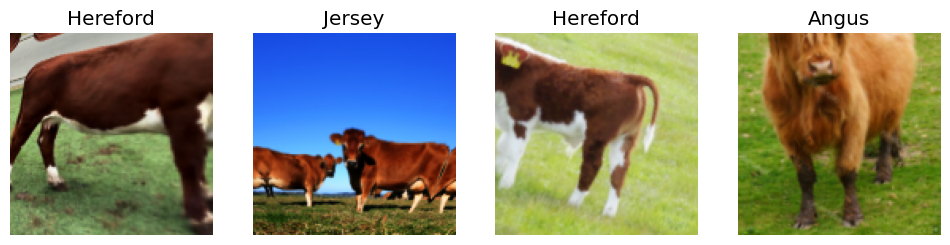

In [86]:
dls.train.show_batch(max_n=4, nrows=1)


In [87]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0004786300996784121, slide=0.002511886414140463)

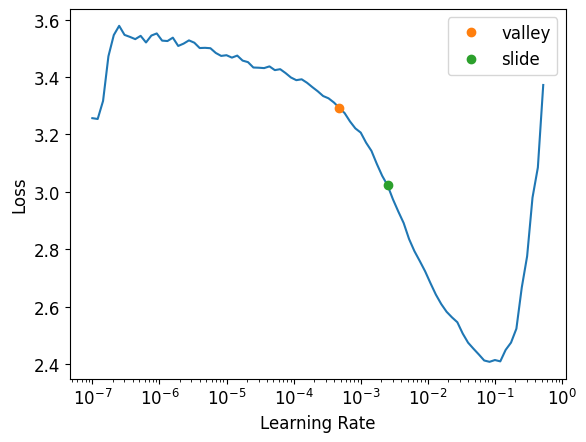

In [88]:
learn.lr_find(suggest_funcs=(valley,slide))

In [94]:
learn.fine_tune(6, 0.001)

epoch,train_loss,valid_loss,error_rate,time
0,0.382028,0.214038,0.069091,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.371173,0.195430,0.061818,01:03
1,0.344044,0.178839,0.047273,00:55
2,0.333175,0.182964,0.050909,00:44
3,0.306070,0.184695,0.050909,00:51
4,0.295340,0.172468,0.050909,00:44
5,0.286107,0.169577,0.050909,00:46


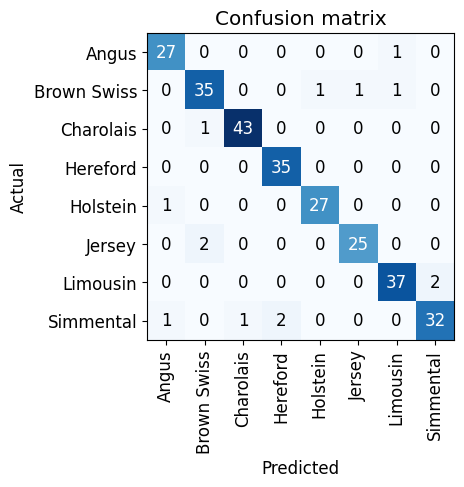

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

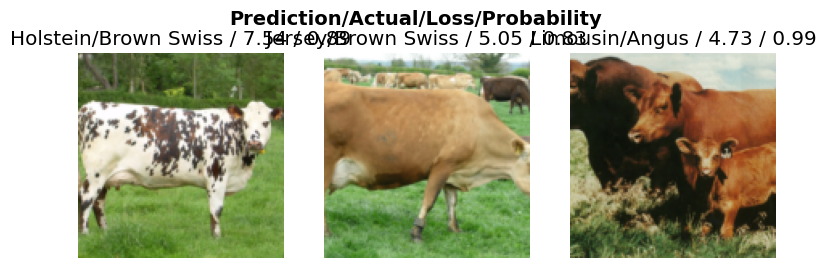

In [101]:
#prediction/actual/lose/probability
interp.plot_top_losses(3, nrows=1) # en buyuk hata oranına sahıp gorsellerı getırır benım oneme.


In [102]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [103]:
def classify_img(path):
    img = PILImage.create(path)
    pred,idx,probs = learn.predict(img)
    return dict(zip(dls.vocab, map(float,probs)))

classify_img('/content/content/what_kind_of_cow/Angus/f8c49401-b8ac-4ba6-8669-0e26a396ab4f.jpg')

{'Angus': 0.7057655453681946,
 'Brown Swiss': 0.0005036041256971657,
 'Charolais': 0.002578263869509101,
 'Hereford': 2.896325895562768e-05,
 'Holstein': 6.6709517341223545e-06,
 'Jersey': 2.1905552785028704e-06,
 'Limousin': 0.2911108136177063,
 'Simmental': 3.935414952138672e-06}

In [107]:
learn.export('model_cow.pkl')